In [148]:
import sys
import warnings
#from torchtext import data

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

from keras import backend as K
import keras
import os, re, sys
import pandas as pd
from keras.utils import to_categorical
import ast
from sklearn.utils import class_weight
from keras.preprocessing import sequence
from keras.models import load_model
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk import WordNetLemmatizer
import itertools
from collections import Counter
from os import listdir
from os.path import isfile, join
import  json


from  keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D, Input
from keras.models import Model

## Generación de data Train/Val/test

In [2]:
stoplist = stopwords.words('english')
lemmatizer=WordNetLemmatizer()

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

def cleaner(post):       
    s= re.sub(r"http\S+", " <url> ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " <hashtag> ", s) ########3
    s= re.sub(r'@\w+ ?', " <user> ", s)##############    
    s= s.lower()
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " <number> ",  s)
    s=re.sub(r'\b[0-9][0-9]\b', " <number> ",  s)
    s=re.sub(r'\b[0-9][0-9][0-9]\b', " <number> ",  s)
    s=re.sub(r'\b[0-9][0-9][0-9][0-9]\b', " <number> ",  s)
    s=emoji_pattern.sub(r'', s)
    s= list(s.split())
    s=[lemmatizer.lemmatize(token) for token in s]
        
    return s

In [3]:
df_train=pd.read_csv("Train_data_compeition.csv")
df_val=pd.read_csv("Validation_data_competition.csv")
df_test=pd.read_csv("testset-competition.csv")
df_train.head()

,Unnamed: 0,tweet_content,harassment,IndirectH,PhysicalH,SexualH
0,0,pics mexican school girl naked melanie safka f...,1,0,0,1
1,1,RT shereiqns Having curly hair is a gotdamn ch...,0,0,0,0
2,2,BreakingNews 7 Unexplained Prisoners Deaths M...,0,0,0,0
3,3,girl dirty quarterback latino pokemon young h...,1,0,0,1
4,4,miliondollameat sexting n ngirl daddy n nme l...,1,0,0,1


In [4]:
df_train.describe()

,Unnamed: 0,harassment,IndirectH,PhysicalH,SexualH
count,6374.00000,6374.000000,6374.000000,6374.000000,6374.000000
mean,3186.50000,0.425635,0.008629,0.011923,0.405083
std,1840.15964,0.494478,0.092497,0.108550,0.490947
min,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1593.25000,0.000000,0.000000,0.000000,0.000000
50%,3186.50000,0.000000,0.000000,0.000000,0.000000
75%,4779.75000,1.000000,0.000000,0.000000,1.000000
max,6373.00000,1.000000,1.000000,1.000000,1.000000


In [5]:
from collections import Counter
print ("conteo de tweets clase Harassment",Counter(df_train['harassment']))
print ("conteo de tweets clase IndirectH",Counter(df_train['IndirectH']))
print ("conteo de tweets clase PhysicalH",Counter(df_train['PhysicalH']))
print ("conteo de tweets clase SexualH",Counter(df_train['SexualH']))

conteo de tweets clase Harassment Counter({0: 3661, 1: 2713})
conteo de tweets clase IndirectH Counter({0: 6319, 1: 55})
conteo de tweets clase PhysicalH Counter({0: 6298, 1: 76})
conteo de tweets clase SexualH Counter({0: 3792, 1: 2582})


In [6]:
y_train_bi=df_train['harassment'].values
y_train_bi[:20]
#labels_mul= 0:non-harassment, 1:harassment, 2:IndirectH, 3:PhysicalH, 4:SexualH


array([1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0])

In [7]:
type(y_train_bi)

numpy.ndarray

In [8]:
y_train_bic=to_categorical(y_train_bi,num_classes=2)
print (y_train_bic[0:10])
y_train_bic.shape

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


(6374, 2)

In [9]:
ys=df_train.values[:,2:]

y_train_mul=np.zeros((df_train.shape[0],5))
i=0
for label in ys:
    if np.sum(label)==0:
        y_train_mul[i][0]=1
    else: 
        y_train_mul[i]=np.concatenate([[0,0],label[1:]])
    i+=1
y_train_mul

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [10]:
y_train_mul[:20]

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [11]:
data_train=[]
for tw in df_train['tweet_content']:
    data_train.append(cleaner(tw))
print (data_train[:5])

[['pic', 'mexican', 'school', 'girl', 'naked', 'melanie', 'safka', 'fake', 'nude', 'photo', 'hardcore', 'slut', 'movie', 'alicia', 'moore', 'porn', 'star', 'toon', 'love'], ['rt', 'shereiqns', 'having', 'curly', 'hair', 'is', 'a', 'gotdamn', 'chore', 'do', 'not', 'let', 'the', 'internet', 'fool', 'you', 'ok'], ['breakingnews', '<number>', 'unexplained', 'prisoner', 'death', 'murder', 'amp', '<number>', 'attempted', 'suicide', 'samswey', 'shacking', 'sifill', 'ldf'], ['girl', 'dirty', 'quarterback', 'latino', 'pokemon', 'young', 'handjob', 'kissing', 'gangbang', 'w', 'x89', 't', 'co', 'wrm4xo00vj'], ['miliondollameat', 'sexting', 'n', 'ngirl', 'daddy', 'n', 'nme', 'listen', 'bitch', 'gonna', 'watch', 'these', 'what']]


In [12]:
embeddings_index = {}
f = open(os.path.join("/home/cony/Documentos/Milenio/twitter15/glove.twitter.27B.200d.txt"))#'glove.twitter.27B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Se encontraron %s terminos con sus vectores de embedding.' % len(embeddings_index))

Se encontraron 1193514 terminos con sus vectores de embedding.


In [13]:
word_index=dict()
j=1
for frase in data_train:
    for term in frase:
        if term not in word_index.keys():
            word_index[term]=j
            j+=1
    
len(word_index.keys())

16188

In [14]:
embedding_vector=200
embedding_matrix = np.zeros((len(word_index.keys())+1, embedding_vector))   #puede probar otra inicialización

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector



In [15]:
Counter(y_train_bi)

Counter({0: 3661, 1: 2713})

In [16]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train_bi), y_train_bi)#{0: 3.,   1: 6.,   2: 5.,  3: 3.}
print (class_weights)

[0.87052718 1.17471434]


In [17]:
from keras.preprocessing import sequence

x_new_train = [[word_index[word] for word in text] for text in data_train]
print(x_new_train[0:2])

print (data_train[0])
print (data_train[1])

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]]
['pic', 'mexican', 'school', 'girl', 'naked', 'melanie', 'safka', 'fake', 'nude', 'photo', 'hardcore', 'slut', 'movie', 'alicia', 'moore', 'porn', 'star', 'toon', 'love']
['rt', 'shereiqns', 'having', 'curly', 'hair', 'is', 'a', 'gotdamn', 'chore', 'do', 'not', 'let', 'the', 'internet', 'fool', 'you', 'ok']


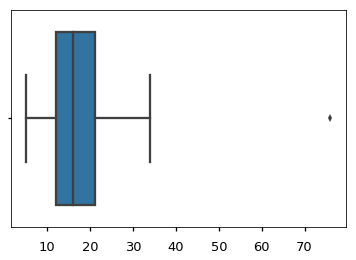

In [18]:
import seaborn as sns
sns.boxplot(list(map(len,x_new_train)))

In [19]:
max_input_lenght = max(list(map(len,x_new_train))) #modificar este valor en base a su experimentación
X_train = sequence.pad_sequences(x_new_train,maxlen=max_input_lenght,padding='post',value=0)
print (max_input_lenght) 
X_train.shape

76


(6374, 76)

#### Carga data Validación

In [20]:
print ("conteo de tweets clase Harassment",Counter(df_val['harassment']))
print ("conteo de tweets clase IndirectH",Counter(df_val['IndirectH']))
print ("conteo de tweets clase PhysicalH",Counter(df_val['PhysicalH']))
print ("conteo de tweets clase SexualH",Counter(df_val['SexualH']))
y_val_bin=df_val['harassment'].values
y_val_bin[:20]

conteo de tweets clase Harassment Counter({0: 1493, 1: 632})
conteo de tweets clase IndirectH Counter({0: 2054, 1: 71})
conteo de tweets clase PhysicalH Counter({0: 2089, 1: 36})
conteo de tweets clase SexualH Counter({0: 1600, 1: 525})


array([0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1])

In [21]:
ys_v=df_val.values[:,2:]

y_val_mul=np.zeros((df_val.shape[0],5))
i=0
for label in ys_v:
    if np.sum(label)==0:
        y_val_mul[i][0]=1
    else: 
        y_val_mul[i]=np.concatenate([[0,0],label[1:]])
    i+=1
y_val_mul

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [22]:
data_val=[]
for tw in df_val['tweet_content']:
    data_val.append(cleaner(tw))
print (data_val[:5])

[['rt', 'glossphoenix', 'some', 'of', 'y', 'all', 'never', 'watched', 'collected', 'and', 'fucked', 'with', 'the', 'bratz', 'movie', 'and', 'it', 'show'], ['omg', 'can', 't', 'believe', 'i', 'm', 'doing', 'this', 'selling', 'my', 'dropbox', 'folder', 'w', '<number>', 'nude', 'amp', '<number>', 'video', 'amp', 'dming', 'a', 'live', 'nude', 'f'], ['asa', 'akira', 'ava', 'lauren', 'beach', 'sex', 'free', 'porn', 'video', 'french', 'anal', 'ftm', 'porn', 'fuck', 'me', 'hard', 'mature', 'sex', 'milf', 'anal', 'pokemon', 'hent'], ['anyone', 'sassy', 'smart', 'mouth', 'cuuuuteeee', 'old', 'favorite', 'word', 'x89', 'x89', 'amp', 'x89', 'boo', 'x89', 'x9d', 'y', 'x89', 'all', 'sh', 'x89', 't', 'co', 'aqxguisj2x'], ['this', 'is', 'why', 'you', 're', 'scared', 'of', 'karma', 'you', 'got', 'to', 'know', 'it', 's', 'gonna', 'be', 'a', 'bitch', 'what', 'you', 'do', 'to', 'our', 'baby', 'will', 'happen']]


In [23]:
Counter(y_val_bin)

Counter({0: 1493, 1: 632})

In [24]:
Vec_train=[]
tweets_c_a=data_train
vocab_train=[]
vocab=list(embeddings_index.keys())
for post in tweets_c_a:
    posteo=[]
    for term in post:   #para todos los terminos de un tweet 
        vector=embeddings_index.get(term)
        if vector is None:       
            posteo.append(np.zeros(200))
        else:
            posteo.append(np.asarray(vector))
            vocab_train.append(term)
    Vec_train.append(np.asarray(posteo))

In [25]:
Vec_val_ig=[]
tweets_l_vali=data_val
vocab=list(embeddings_index.keys())
for post in tweets_l_vali:
    temp=[]
    for term in post:  
        if term in vocab_train:
            vector=embeddings_index.get(term)
            if vector is None:       
                temp.append(np.zeros(200))
            else:
                temp.append(np.asarray(vector))
    Vec_val_ig.append(temp)

In [26]:
df_val.shape

(2125, 6)

In [27]:
np.asarray(Vec_val_ig).shape

(2125,)

In [28]:
all_val=[]
for text in data_val:
    temp=[]
    for word in text:
        try:
            temp.append(word_index[word])
        except:
            continue
    all_val.append(temp)

In [29]:
x_new_val=all_val

print(x_new_val[0:2])
print (data_val[:2])
len(all_val)


[[20, 1526, 422, 438, 393, 664, 159, 12417, 142, 367, 318, 32, 13, 142, 95, 192], [3413, 94, 60, 521, 97, 143, 122, 117, 1407, 113, 1408, 58, 38, 9, 43, 38, 443, 43, 1976, 26, 111, 9, 282]]
[['rt', 'glossphoenix', 'some', 'of', 'y', 'all', 'never', 'watched', 'collected', 'and', 'fucked', 'with', 'the', 'bratz', 'movie', 'and', 'it', 'show'], ['omg', 'can', 't', 'believe', 'i', 'm', 'doing', 'this', 'selling', 'my', 'dropbox', 'folder', 'w', '<number>', 'nude', 'amp', '<number>', 'video', 'amp', 'dming', 'a', 'live', 'nude', 'f']]


2125

In [30]:
X_val_ig = sequence.pad_sequences(x_new_val,maxlen=max_input_lenght,padding='post',value=0)
print (np.asarray(X_val_ig).shape)

(2125, 76)


In [31]:
y_val_bin[:5]

array([0, 0, 1, 0, 1])

In [32]:
y_val_bic=to_categorical(y_val_bin,num_classes=2)
print (y_val_bic[0:10])
y_val_bic.shape

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


(2125, 2)

In [33]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
from sklearn.preprocessing import normalize
import time

def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Modelo Conv


In [34]:
from  keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D, Input
from keras.models import Model

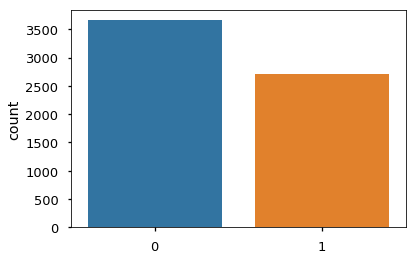

In [35]:
sns.countplot(y_train_bi)

In [36]:
from keras import backend as K

def focal_loss(gamma=2., weights=1):   #weights np.asarray()
    weights= K.variable(weights)
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.clip(y_true, K.epsilon(),1)
        y_pred = K.clip(y_pred,K.epsilon(),1)
        return - K.sum(weights* K.pow(1. - y_pred, gamma)* y_true * K.log(y_pred), axis=-1) 
    return focal_loss_fixed

In [58]:
embedding_vector=200
embedding_layer = Embedding(input_dim=len(word_index.keys())+1,output_dim=embedding_vector,weights=[embedding_matrix],
                     input_length=max_input_lenght,trainable=False)

sequence_input = Input(shape=(max_input_lenght,))
embedded_sequences = embedding_layer(sequence_input)
batch = BatchNormalization()(embedded_sequences)
cov1= Conv1D(128, 5, activation='relu',padding='same')(batch)
pool = MaxPooling1D(pool_size=3)(cov1)    
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
cov1= Conv1D(64, 5, activation='relu',padding='same')(drop)
pool = MaxPooling1D(pool_size=3)(cov1)
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
flat = Flatten()(drop)
preds = Dense(64, activation='relu')(flat)
preds = BatchNormalization()(preds)
preds = Dense(1, activation='sigmoid')(preds)
model = Model(sequence_input, preds)
#model.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 76)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 76, 200)           3237800   
_________________________________________________________________
batch_normalization_17 (Batc (None, 76, 200)           800       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 76, 128)           128128    
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 25, 128)           0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 25, 128)           512       
_________________________________________________________________
dropout_9 (Dropout)          (None, 25, 128)           0         
__________

In [38]:
X_train.shape

(6374, 76)

In [39]:
y_train_bi.shape

(6374,)

In [40]:
X_val_ig.shape

(2125, 76)

In [41]:
y_val_bic.shape

(2125, 2)

In [59]:
history = model.fit(X_train, y_train_bi,batch_size=64,epochs=10,verbose=1,validation_data=(X_val_ig,y_val_bin),class_weight=class_weights)

ValueError: Error when checking target: expected dense_10 to have shape (1,) but got array with shape (2,)

In [43]:
y_val_bic[:4]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [44]:
trainPredict = model.predict(X_val_ig, batch_size=64)
print (trainPredict[:5])
trainPredict=[np.round(pred) for pred in trainPredict]
print (trainPredict[:5])
acc_val= accuracy_score(y_val_bin, trainPredict)
f1_val=f1_score(y_val_bin, trainPredict, average=None)  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(y_val_bin, trainPredict, average='macro')  # labels=np.unique(trainPredict)
rec=recall_score(y_val_bin, trainPredict, average=None) 
pre=precision_score(y_val_bin, trainPredict, average=None) 
matriz_val=confusion_matrix(y_val_bin, trainPredict)

print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

[[0.01088028]
 [0.04776569]
 [0.90129995]
 [0.00311063]
 [0.5014824 ]]
[array([0.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32)]
Accuracy sobre validacion: 0.8903529411764706
F1-score None sobre validación: [0.92577254 0.79027903]
F1-score macro sobre validación: 0.8580257834639787
Precision None sobre validación: [0.88274605 0.91649269]
Recall None sobre validación: [0.97320831 0.69462025]


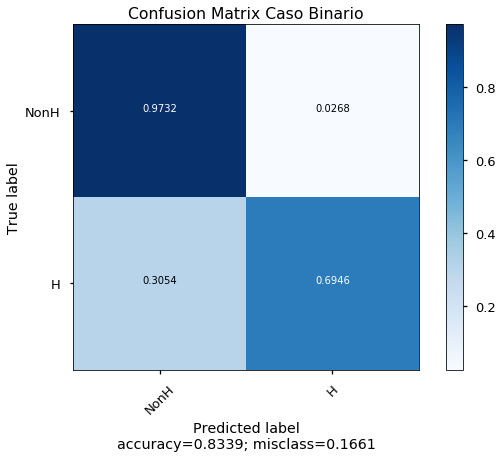

In [45]:
plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),["NonH","H"],"Confusion Matrix Caso Binario")

#.91129547 0.88351254]
#Recall None sobre validación: [0.9564635  0.780063
(0.8835+0.7800)/2

In [66]:
# lo mismo con focal 
embedding_vector=200
embedding_layer = Embedding(input_dim=len(word_index.keys())+1,output_dim=embedding_vector,weights=[embedding_matrix],
                     input_length=max_input_lenght,trainable=False)

sequence_input = Input(shape=(max_input_lenght,))
embedded_sequences = embedding_layer(sequence_input)
batch = BatchNormalization()(embedded_sequences)
cov1= Conv1D(128, 5, activation='relu',padding='same')(batch)
pool = MaxPooling1D(pool_size=3)(cov1)    
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
cov1= Conv1D(64, 5, activation='relu',padding='same')(drop)
pool = MaxPooling1D(pool_size=3)(cov1)
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
flat = Flatten()(drop)
preds = Dense(64, activation='relu')(flat)
preds = BatchNormalization()(preds)
preds = Dense(2, activation='softmax')(preds)
model = Model(sequence_input, preds)
model.compile(loss=focal_loss(2),optimizer='adam',metrics=['acc'])
#model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 76)                0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 76, 200)           3237800   
_________________________________________________________________
batch_normalization_29 (Batc (None, 76, 200)           800       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 76, 128)           128128    
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 25, 128)           0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 25, 128)           512       
_________________________________________________________________
dropout_15 (Dropout)         (None, 25, 128)           0         
__________

In [67]:
history = model.fit(X_train, y_train_bic,batch_size=64,epochs=10,verbose=1,validation_data=(X_val_ig,y_val_bic),class_weight=class_weights)

Train on 6374 samples, validate on 2125 samples
Epoch 1/10
6374/6374 [==============================] - 22s 3ms/step - loss: 0.3156 - acc: 0.6567 - val_loss: 0.0982 - val_acc: 0.8607
Epoch 2/10
6374/6374 [==============================] - 21s 3ms/step - loss: 0.1616 - acc: 0.7628 - val_loss: 0.1089 - val_acc: 0.8405
Epoch 3/10
6374/6374 [==============================] - 20s 3ms/step - loss: 0.1245 - acc: 0.8031 - val_loss: 0.0908 - val_acc: 0.8579
Epoch 4/10
6374/6374 [==============================] - 20s 3ms/step - loss: 0.1099 - acc: 0.8306 - val_loss: 0.0757 - val_acc: 0.8936
Epoch 5/10
6374/6374 [==============================] - 20s 3ms/step - loss: 0.1060 - acc: 0.8372 - val_loss: 0.0784 - val_acc: 0.8824
Epoch 6/10
6374/6374 [==============================] - 20s 3ms/step - loss: 0.0984 - acc: 0.8486 - val_loss: 0.0811 - val_acc: 0.8762
Epoch 7/10
6374/6374 [==============================] - 20s 3ms/step - loss: 0.0930 - acc: 0.8577 - val_loss: 0.0723 - val_acc: 0.9021
Epoch 8

[0 0 1 0 1]
Accuracy sobre validacion: 0.904
F1-score None sobre validación: [0.93333333 0.82857143]
F1-score macro sobre validación: 0.8809523809523809
Precision None sobre validación: [0.91129547 0.88351254]
Recall None sobre validación: [0.9564635  0.78006329]


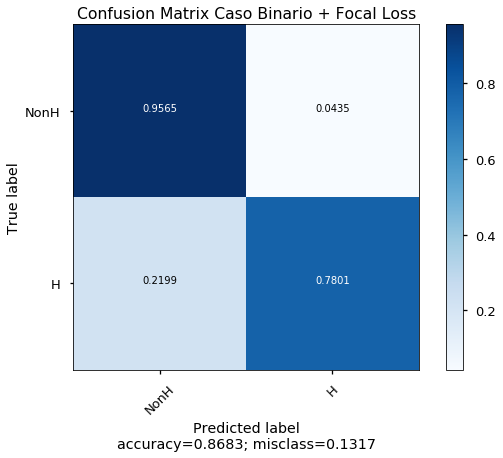

In [68]:
trainPredict = model.predict(X_val_ig, batch_size=64).argmax(axis=-1)
print (trainPredict[:5])
acc_val= accuracy_score(y_val_bin, trainPredict)
f1_val=f1_score(y_val_bin, trainPredict, average=None)  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(y_val_bin, trainPredict, average='macro')  # labels=np.unique(trainPredict)
rec=recall_score(y_val_bin, trainPredict, average=None) 
pre=precision_score(y_val_bin, trainPredict, average=None) 
matriz_val=confusion_matrix(y_val_bin, trainPredict)

print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),["NonH","H"],"Confusion Matrix Caso Binario + Focal Loss")

In [96]:
embedding_vector=200
embedding_layer = Embedding(input_dim=len(word_index.keys())+1,output_dim=embedding_vector,weights=[embedding_matrix],
                     input_length=max_input_lenght,trainable=False)

sequence_input = Input(shape=(max_input_lenght,))
embedded_sequences = embedding_layer(sequence_input)
batch = BatchNormalization()(embedded_sequences)
cov1= Conv1D(128, 5, activation='relu',padding='same')(batch)
pool = MaxPooling1D(pool_size=3)(cov1)    

batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
cov1= Conv1D(64, 5, activation='relu',padding='same')(drop)
pool = MaxPooling1D(pool_size=3)(cov1)
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
flat = Flatten()(drop)
preds = Dense(128, activation='relu')(flat)
preds = BatchNormalization()(preds)
preds= Dropout(0.3)(preds)
preds = Dense(2, activation='softmax')(preds)
model2 = Model(sequence_input, preds)
model2.compile(loss=focal_loss(2, weights=class_weights),optimizer='adam',metrics=['acc'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 76)                0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 76, 200)           3237800   
_________________________________________________________________
batch_normalization_41 (Batc (None, 76, 200)           800       
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 76, 128)           128128    
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 25, 128)           0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 25, 128)           512       
_________________________________________________________________
dropout_23 (Dropout)         (None, 25, 128)           0         
__________

In [97]:
history = model2.fit(X_train, y_train_bic,batch_size=64,epochs=10,verbose=1,validation_data=(X_val_ig,y_val_bic),class_weight=class_weights)

Train on 6374 samples, validate on 2125 samples
Epoch 1/10
6374/6374 [==============================] - 21s 3ms/step - loss: 0.4412 - acc: 0.6249 - val_loss: 0.1362 - val_acc: 0.8405
Epoch 2/10
6374/6374 [==============================] - 20s 3ms/step - loss: 0.2086 - acc: 0.7407 - val_loss: 0.0929 - val_acc: 0.8828
Epoch 3/10
6374/6374 [==============================] - 20s 3ms/step - loss: 0.1414 - acc: 0.7885 - val_loss: 0.0926 - val_acc: 0.8744
Epoch 4/10
6374/6374 [==============================] - 20s 3ms/step - loss: 0.1223 - acc: 0.8114 - val_loss: 0.0858 - val_acc: 0.8776
Epoch 5/10
6374/6374 [==============================] - 22s 3ms/step - loss: 0.1078 - acc: 0.8342 - val_loss: 0.0777 - val_acc: 0.8960
Epoch 6/10
6374/6374 [==============================] - 20s 3ms/step - loss: 0.0984 - acc: 0.8480 - val_loss: 0.0820 - val_acc: 0.8866
Epoch 7/10
6374/6374 [==============================] - 19s 3ms/step - loss: 0.0930 - acc: 0.8593 - val_loss: 0.0808 - val_acc: 0.8885
Epoch 8

[0 0 1 0 1]
Accuracy sobre validacion: 0.8931764705882353
F1-score None sobre validación: [0.9272669  0.79893711]
F1-score macro sobre validación: 0.8631020070615099
Precision None sobre validación: [0.88882064 0.90744467]
Recall None sobre validación: [0.96918955 0.71360759]


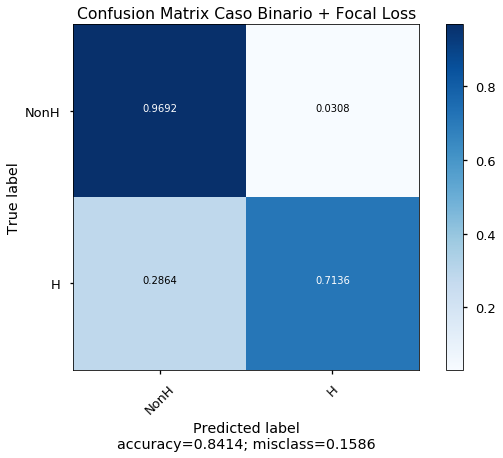

In [98]:
trainPredict = model2.predict(X_val_ig, batch_size=64).argmax(axis=-1)
print (trainPredict[:5])
acc_val= accuracy_score(y_val_bin, trainPredict)
f1_val=f1_score(y_val_bin, trainPredict, average=None)  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(y_val_bin, trainPredict, average='macro')  # labels=np.unique(trainPredict)
rec=recall_score(y_val_bin, trainPredict, average=None) 
pre=precision_score(y_val_bin, trainPredict, average=None) 
matriz_val=confusion_matrix(y_val_bin, trainPredict)

print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),["NonH","H"],"Confusion Matrix Caso Binario + Focal Loss")

Mejor modelo para la fase uno (caso bibnario) corresponde a la evaluación en focal loss con 10 epochs

### Caso multiclass

In [80]:
unnamed_har=np.where(df_train['harassment']== 1)[0]
len(unnamed_har)

2713

In [88]:
unnamed_har_val=np.where(df_val['harassment']== 1)[0]
len(unnamed_har_val)

632

In [84]:
df_train.values[unnamed_har].shape

(2713, 6)

In [87]:
df_train_f2=pd.DataFrame(df_train.values[unnamed_har], columns=['unnamed_har', 'tweet','harassment','IndirectH','PhysicalH','SexualH'])
df_train_f2.head()

,unnamed_har,tweet,harassment,IndirectH,PhysicalH,SexualH
0,0,pics mexican school girl naked melanie safka f...,1,0,0,1
1,3,girl dirty quarterback latino pokemon young h...,1,0,0,1
2,4,miliondollameat sexting n ngirl daddy n nme l...,1,0,0,1
3,6,museum slut If you know somewhere we can do i...,1,0,0,1
4,7,RT sp00kybitchhhh I have spots open Sissy Slut...,1,0,0,1


In [90]:
df_val.head()

,Unnamed: 0,tweet_content,harassment,IndirectH,PhysicalH,SexualH
0,6374,RT GLOSSPHOENIX some of y all never watched co...,0,0,0,0
1,6375,OMG CAN T BELIEVE I M DOING THIS Selling my Dr...,0,0,0,0
2,6376,asa akira ava lauren beach sex free porn video...,1,0,0,1
3,6377,Anyone sassy smart mouth cuuuuteeee old favor...,0,0,0,0
4,6378,This is why you re scared of Karma you got to ...,1,0,0,1


In [89]:
df_val_f2=pd.DataFrame(df_val.values[unnamed_har_val], columns=['unnamed_har', 'tweet','harassment','IndirectH','PhysicalH','SexualH'])
df_val_f2.head()

,unnamed_har,tweet,harassment,IndirectH,PhysicalH,SexualH
0,6376,asa akira ava lauren beach sex free porn video...,1,0,0,1
1,6378,This is why you re scared of Karma you got to ...,1,0,0,1
2,6381,tit mouth office lesbians elegant creampie ea...,1,0,0,1
3,6383,But heard homeless woman twelve x89 she x89 s...,1,0,0,1
4,6384,love you bby RT and Like for more single girl...,1,0,0,1


In [91]:
data_train_f2=[]
for tw in df_train_f2['tweet']:
    data_train_f2.append(cleaner(tw))
print (data_train_f2[:5])


[['pic', 'mexican', 'school', 'girl', 'naked', 'melanie', 'safka', 'fake', 'nude', 'photo', 'hardcore', 'slut', 'movie', 'alicia', 'moore', 'porn', 'star', 'toon', 'love'], ['girl', 'dirty', 'quarterback', 'latino', 'pokemon', 'young', 'handjob', 'kissing', 'gangbang', 'w', 'x89', 't', 'co', 'wrm4xo00vj'], ['miliondollameat', 'sexting', 'n', 'ngirl', 'daddy', 'n', 'nme', 'listen', 'bitch', 'gonna', 'watch', 'these', 'what'], ['museum', 'slut', 'if', 'you', 'know', 'somewhere', 'we', 'can', 'do', 'it', 'then', 'i', 'am', 'game'], ['rt', 'sp00kybitchhhh', 'i', 'have', 'spot', 'open', 'sissy', 'slut', 'intox', 'bitch', 'human', 'atm', 'amazon', 'boy', 'do', 'you', 'have', 'what', 'it', 'take', 'can', 'you', 'live', 'up', 'to', 'my']]


In [92]:
word_index_f2=dict()
j=1
for frase in data_train_f2:
    for term in frase:
        if term not in word_index_f2.keys():
            word_index_f2[term]=j
            j+=1
    
len(word_index_f2.keys())

7615

In [93]:
embedding_vector=200
embedding_matrix_f2 = np.zeros((len(word_index_f2.keys())+1, embedding_vector))   #puede probar otra inicialización

for word, i in word_index_f2.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_f2[i] = embedding_vector


In [106]:
y_train_f2=np.asarray(np.asarray(df_train_f2.values)[:,-3:],dtype='float32')
y_train_f2[:20]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [110]:
y_train_mu=[] #123
for array in y_train_f2:
    y_train_mu.append(np.argmax(array))
y_train_mul=to_categorical(y_train_mu,num_classes=3)
#print (y_train_mul[:10])
y_train_mul.shape#one hot

(2713, 3)

In [111]:
class_weights_f2 = class_weight.compute_class_weight('balanced', np.unique(y_train_mu), y_train_mu)
print (class_weights_f2)

[16.44242424 11.89912281  0.35024529]


In [124]:
c = Counter(y_train_mu)
c = sorted(c.items())
print (c)
clases=['Indirect','Physical','Sexual']
class_num = [i[0] for i in c]
class_names = [clases[i[0]-1] for i in c]
freq = [i[1] for i in c]
#plt.bar(y_train_mu)

[(0, 55), (1, 76), (2, 2582)]


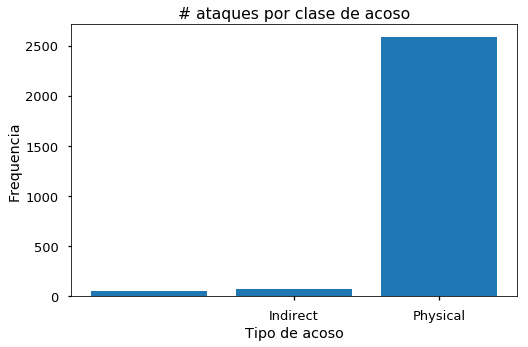

In [125]:
f, ax = plt.subplots(figsize=(8,5))
plt.bar(class_num, freq)
plt.title("# ataques por clase de acoso")
plt.xlabel("Tipo de acoso")
plt.ylabel("Frequencia")
ax.set_xticks(range(0, 3))
ax.set_xticklabels(clases)

plt.show()

In [128]:
from keras.preprocessing import sequence

x_new_train = [[word_index_f2[word] for word in cleaner(text)] for text in df_train_f2["tweet"].values]
print(x_new_train[0:2])

print (df_train_f2["tweet"].values[:2])
#print (df_train_f2["tweet"].values[1])

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [4, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]]
['pics mexican school girl naked melanie safka fake nude photos hardcore slut movies alicia moore porn star toon love '
 ' girl dirty quarterback latino pokemon young handjob kissing gangbang w x89 t co Wrm4xo00vJ ']


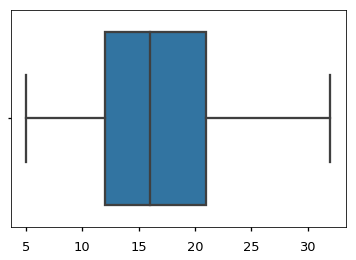

In [129]:
sns.boxplot(list(map(len,x_new_train)))

In [131]:
max_input_lenght = max(list(map(len,x_new_train))) #modificar este valor en base a su experimentación
X_train_f2 = sequence.pad_sequences(x_new_train,maxlen=max_input_lenght,padding='post',value=0)

In [133]:
X_train_f2.shape

(2713, 32)

In [134]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
from sklearn.preprocessing import normalize
import time

def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [136]:
list_posts=[cleaner(text) for text in df_train_f2["tweet"].values]  #train
print (len(list_posts))

Vec_train=[]
tweets_c_a=list_posts
vocab_train_f2=[]
vocab=list(embeddings_index.keys())
for post in list_posts:
    posteo=[]
    for term in post:   #para todos los terminos de un tweet 
        vector=embeddings_index.get(term)
        if vector is None:       
            posteo.append(np.zeros(200))
        else:
            posteo.append(np.asarray(vector))
            vocab_train_f2.append(term)
    Vec_train.append(np.asarray(posteo))

2713


In [137]:
list_posts_val=[cleaner(text) for text in df_val_f2["tweet"].values]  #train
print (len(list_posts_val))

Vec_val_ig=[]
vocab=list(embeddings_index.keys())
for post in list_posts_val:
    temp=[]
    for term in post:   #para todos los terminos de un tweet 
        if term in vocab_train_f2:
            vector=embeddings_index.get(term)
            if vector is None:       
                temp.append(np.zeros(200))
            else:
                temp.append(np.asarray(vector))
    Vec_val_ig.append(temp)

632


In [139]:
word_index_f2_val=dict()
j=1
for frase in list_posts_val:
    for term in frase:
        if term not in word_index_f2_val.keys():
            word_index_f2_val[term]=j
            j+=1
            
all_val_dif=[]
for text in list_posts_val:
    temp=[]
    for word in text:
        try:
            temp.append(word_index_f2_val[word])
        except:
            continue
    all_val_dif.append(temp)

all_val=[]
for text in list_posts_val:
    temp=[]
    for word in text:
        try:
            temp.append(word_index_f2[word])
        except:
            continue
    all_val.append(temp)


In [144]:
x_new_val=all_val#.copy()
print(x_new_val[0:2])
print (list_posts_val[:2])

[[326, 877, 3106, 319, 674, 16, 254, 1709, 469, 16, 211, 87, 1254, 467, 319, 903, 469, 23], [282, 202, 852, 47, 151, 2037, 255, 2400, 47, 596, 72, 48, 53, 79, 41, 157, 159, 40, 44, 47, 52, 72, 2307, 960, 113, 1217]]
[['asa', 'akira', 'ava', 'lauren', 'beach', 'sex', 'free', 'porn', 'video', 'french', 'anal', 'ftm', 'porn', 'fuck', 'me', 'hard', 'mature', 'sex', 'milf', 'anal', 'pokemon', 'hent'], ['this', 'is', 'why', 'you', 're', 'scared', 'of', 'karma', 'you', 'got', 'to', 'know', 'it', 's', 'gonna', 'be', 'a', 'bitch', 'what', 'you', 'do', 'to', 'our', 'baby', 'will', 'happen']]


In [145]:
X_val_ig = sequence.pad_sequences(x_new_val,maxlen=max_input_lenght,padding='post',value=0)
print (np.asarray(X_val_ig).shape)

(632, 32)


In [146]:
y_val_f2=np.asarray(np.asarray(df_val_f2.values)[:,-3:],dtype='float32')
y_val_mu=[] #123
for array in y_val_f2:
    y_val_mu.append(np.argmax(array))
y_val_mul=to_categorical(y_val_mu,num_classes=3)
y_val_mul.shape#one hot

(632, 3)

[(0, 71), (1, 36), (2, 525)]


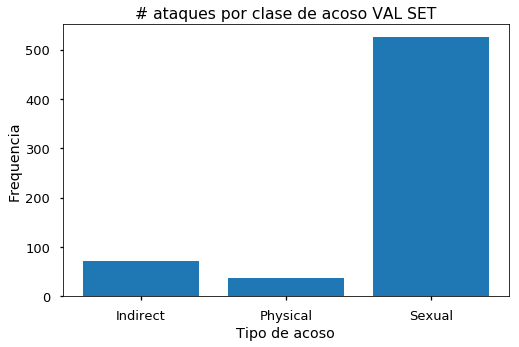

In [161]:
c = Counter(y_val_mu)
c = sorted(c.items())
print (c)
clases=['Indirect','Physical','Sexual']
class_num = [i[0] for i in c]
class_names = [clases[i[0]-1] for i in c]
freq = [i[1] for i in c]
#plt.bar(y_train_mu)

f, ax = plt.subplots(figsize=(8,5))
plt.bar(class_num, freq)
plt.title("# ataques por clase de acoso VAL SET")
plt.xlabel("Tipo de acoso")
plt.ylabel("Frequencia")
ax.set_xticks(range(0, 3))
ax.set_xticklabels(clases)

plt.show()

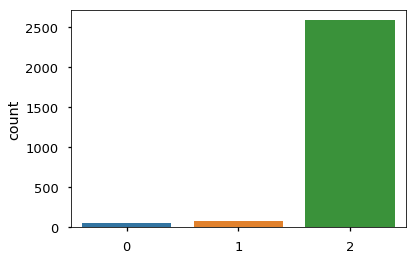

In [150]:
sns.countplot(y_train_f2.argmax(axis=1))

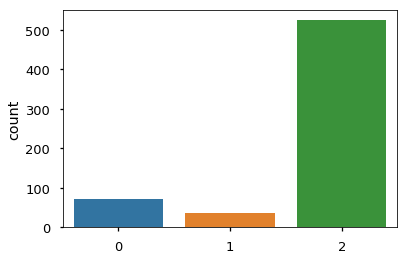

In [151]:
sns.countplot(y_val_f2.argmax(axis=1))

### Conv 1

In [152]:
embedding_vector=200
embedding_layer = Embedding(input_dim=len(word_index_f2.keys())+1,output_dim=embedding_vector,weights=[embedding_matrix_f2],
                     input_length=max_input_lenght,trainable=False)

sequence_input = Input(shape=(max_input_lenght,))
embedded_sequences = embedding_layer(sequence_input)
batch = BatchNormalization()(embedded_sequences)
cov1= Conv1D(128, 5, activation='relu',padding='same')(batch)
pool = MaxPooling1D(pool_size=3)(cov1)    
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
cov1= Conv1D(64, 5, activation='relu',padding='same')(drop)
pool = MaxPooling1D(pool_size=3)(cov1)
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
flat = Flatten()(drop)
preds = Dense(100, activation='relu')(flat)
preds = BatchNormalization()(preds)
preds = Dense(3, activation='softmax')(preds)
model = Model(sequence_input, preds)
model.compile(loss=focal_loss(2,weights=class_weights_f2),optimizer='adam',metrics=['acc'])
history = model.fit(X_train_f2, y_train_mul,batch_size=64,epochs=20,verbose=1,validation_data=(X_val_ig,y_val_mul),class_weight=class_weights_f2)   



Train on 2713 samples, validate on 632 samples
Epoch 1/20
2713/2713 [==============================] - 5s 2ms/step - loss: 1.1037 - acc: 0.2919 - val_loss: 1.2060 - val_acc: 0.1582
Epoch 2/20
2713/2713 [==============================] - 4s 1ms/step - loss: 0.8245 - acc: 0.3358 - val_loss: 1.1105 - val_acc: 0.2326
Epoch 3/20
2713/2713 [==============================] - 4s 1ms/step - loss: 0.7191 - acc: 0.3664 - val_loss: 1.1331 - val_acc: 0.2674
Epoch 4/20
2713/2713 [==============================] - 4s 1ms/step - loss: 0.6581 - acc: 0.3922 - val_loss: 1.3787 - val_acc: 0.2911
Epoch 5/20
2713/2713 [==============================] - 4s 1ms/step - loss: 0.6097 - acc: 0.4342 - val_loss: 1.2215 - val_acc: 0.3513
Epoch 6/20
2713/2713 [==============================] - 4s 1ms/step - loss: 0.5592 - acc: 0.4316 - val_loss: 1.2675 - val_acc: 0.3956
Epoch 7/20
2713/2713 [==============================] - 4s 1ms/step - loss: 0.5501 - acc: 0.4254 - val_loss: 1.2337 - val_acc: 0.4810
Epoch 8/20
2713

[2 2 2 2 2]
Accuracy sobre validacion: 0.8465189873417721
F1-score None sobre validación: [0.41818182 0.         0.91592129]
F1-score macro sobre validación: 0.4447010353987098
Precision None sobre validación: [0.58974359 0.         0.86340641]
Recall None sobre validación: [0.32394366 0.         0.9752381 ]


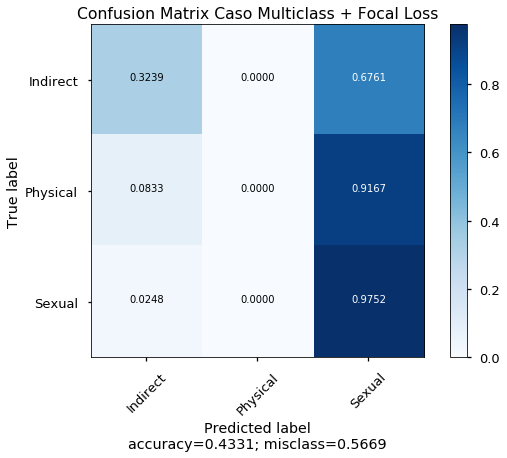

In [153]:
trainPredict = model.predict(X_val_ig, batch_size=64).argmax(axis=-1)
print (trainPredict[:5])
acc_val= accuracy_score(y_val_mu, trainPredict)
f1_val=f1_score(y_val_mu, trainPredict, average=None)  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(y_val_mu, trainPredict, average='macro')  # labels=np.unique(trainPredict)
rec=recall_score(y_val_mu, trainPredict, average=None) 
pre=precision_score(y_val_mu, trainPredict, average=None) 
matriz_val=confusion_matrix(y_val_mu, trainPredict)

print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),['Indirect','Physical','Sexual'],"Confusion Matrix Caso Multiclass + Focal Loss")

In [172]:
embedding_vector=200
embedding_layer = Embedding(input_dim=len(word_index_f2.keys())+1,output_dim=embedding_vector,weights=[embedding_matrix_f2],
                     input_length=max_input_lenght,trainable=False)

sequence_input = Input(shape=(max_input_lenght,))
embedded_sequences = embedding_layer(sequence_input)

batch = BatchNormalization()(embedded_sequences)
cov1= Conv1D(128, 5, activation='relu',padding='same')(batch)
pool = MaxPooling1D(pool_size=3)(cov1)    
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
cov1= Conv1D(64, 5, activation='relu',padding='same')(drop)
pool = MaxPooling1D(pool_size=3)(cov1)
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
flat = Flatten()(drop)
preds = Dense(128, activation='relu')(flat)
preds = BatchNormalization()(preds)
preds= Dropout(0.3)(preds)
preds = Dense(3, activation='softmax')(preds)
model2 = Model(sequence_input, preds)
model2.compile(loss=focal_loss(2,weights=class_weights_f2),optimizer='adam',metrics=['acc'])

In [173]:
history = model2.fit(X_train_f2, y_train_mul,batch_size=64,epochs=20,verbose=1,validation_data=(X_val_ig,y_val_mul),class_weight=class_weights_f2)   

Train on 2713 samples, validate on 632 samples
Epoch 1/20
2713/2713 [==============================] - 7s 3ms/step - loss: 1.3753 - acc: 0.3509 - val_loss: 1.1816 - val_acc: 0.1899
Epoch 2/20
2713/2713 [==============================] - 4s 1ms/step - loss: 0.9664 - acc: 0.3524 - val_loss: 1.0859 - val_acc: 0.1915
Epoch 3/20
2713/2713 [==============================] - 4s 1ms/step - loss: 0.9278 - acc: 0.3730 - val_loss: 1.0124 - val_acc: 0.2104
Epoch 4/20
2713/2713 [==============================] - 4s 1ms/step - loss: 0.8122 - acc: 0.3985 - val_loss: 1.0180 - val_acc: 0.2405
Epoch 5/20
2713/2713 [==============================] - 4s 1ms/step - loss: 0.6574 - acc: 0.4202 - val_loss: 0.9689 - val_acc: 0.2816
Epoch 6/20
2713/2713 [==============================] - 4s 1ms/step - loss: 0.7564 - acc: 0.4419 - val_loss: 0.9328 - val_acc: 0.3054
Epoch 7/20
2713/2713 [==============================] - 4s 1ms/step - loss: 0.7087 - acc: 0.4305 - val_loss: 0.9894 - val_acc: 0.4177
Epoch 8/20
2713

[2 1 2 2 2]
Accuracy sobre validacion: 0.7784810126582279
F1-score None sobre validación: [0.40223464 0.14285714 0.87852284]
F1-score macro sobre validación: 0.47453820581172074
Precision None sobre validación: [0.33333333 0.2        0.8968254 ]
Recall None sobre validación: [0.50704225 0.11111111 0.86095238]


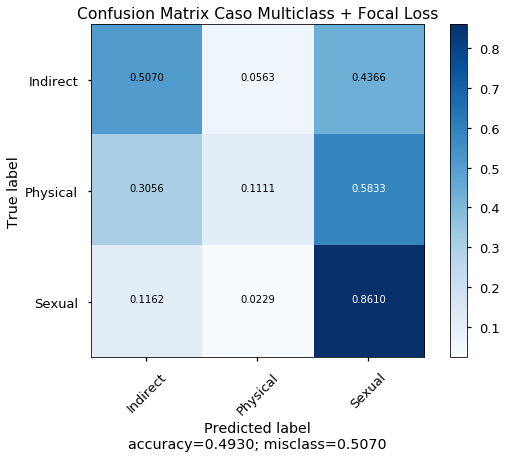

In [174]:
trainPredict = model2.predict(X_val_ig, batch_size=64).argmax(axis=-1)
print (trainPredict[:5])
acc_val= accuracy_score(y_val_mu, trainPredict)
f1_val=f1_score(y_val_mu, trainPredict, average=None)  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(y_val_mu, trainPredict, average='macro')  # labels=np.unique(trainPredict)
rec=recall_score(y_val_mu, trainPredict, average=None) 
pre=precision_score(y_val_mu, trainPredict, average=None) 
matriz_val=confusion_matrix(y_val_mu, trainPredict)

print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),['Indirect','Physical','Sexual'],"Confusion Matrix Caso Multiclass + Focal Loss")

### Utilizando recurrentes